In [3]:
!pip install astroNN --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 22.9 MB/s eta 0:00:00


In [4]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import v2 as transforms
from astroNN.datasets import galaxy10
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
images, labels = galaxy10.load_data()
images = np.transpose(images, axes=(0, 3, 1, 2))

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:55<00:00, 58.5MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [01:04, 42.5MB/s]                            


In [6]:
class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
class MorphologicalOpeningTransform(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)

    def forward(self, img):
        np_img = img if isinstance(img, np.ndarray) else img.numpy()
        morphs = []
        for ch in range(3):
            morphs.append(
                torch.from_numpy(
                    cv2.morphologyEx(np_img[ch], cv2.MORPH_OPEN, self.kernel)
                )
            )

        return torch.stack(morphs)

In [8]:
N_CH, IMG_HEIGHT, IMG_WIDTH = 3, 224, 224

In [9]:
transform = transforms.Compose([
    MorphologicalOpeningTransform((7,7)),
    transforms.CenterCrop(size=(IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToDtype(torch.float),
    transforms.Normalize(mean=(127.5, 127.5, 127.5), std=(127.5, 127.5, 127.5))
])

In [10]:
dataset = Galaxy10Dataset(images, labels, transform=transform)

_, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, shuffle=True, stratify=dataset.labels)

test_dataset = Subset(dataset, test_idx)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
def get_resnet50_model(path):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    model.load_state_dict(torch.load(path, weights_only=True))
    return model

In [12]:
def get_densenet121_model(path):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 10)

    model.load_state_dict(torch.load(path, weights_only=True))
    return model

In [13]:
def get_efficientnet_b0_model(path):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 10)

    model.load_state_dict(torch.load(path, weights_only=True))
    return model

In [14]:
# Muevo el modelo a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
models_weights = ["resnet.pt",
                  "resnet-new-loss.pt",
                  "densenet.pt",
                  "densenet-new-loss.pt",
                  "efficientnet-b0.pt",
                  "efficientnet-b0-new-loss.pt"]

In [16]:
results = {}

for model_path in models_weights:
    if("resnet" in model_path):
        model = get_resnet50_model(model_path)
    elif("densenet" in model_path):
        model = get_densenet121_model(model_path)
    else:
        model = get_efficientnet_b0_model(model_path)

    model = model.to(device)
    model.eval()

    y = []
    y_hat = []
    for data in test_loader:
        x_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()

        nnet_output = model(x_batch)
        y_batch_hat = torch.argmax(nnet_output, dim=1)

        y += list(y_batch.detach().cpu().numpy())
        y_hat += list(y_batch_hat.detach().cpu().numpy())

    results[model_path.split(".")[0]] = (y, y_hat)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 104MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


In [17]:
model_names = { "resnet": "ResNet-50",
                "resnet-new-loss": "ResNet-50 (NGL)",
                "densenet": "DenseNet-121",
                "densenet-new-loss": "DenseNet-121 (NGL)",
                "efficientnet-b0": "EficcientNet B0",
                "efficientnet-b0-new-loss": "EfficientNet B0 (NGL)"
              }

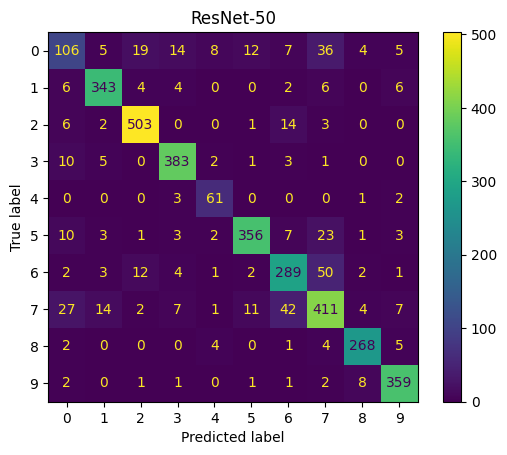

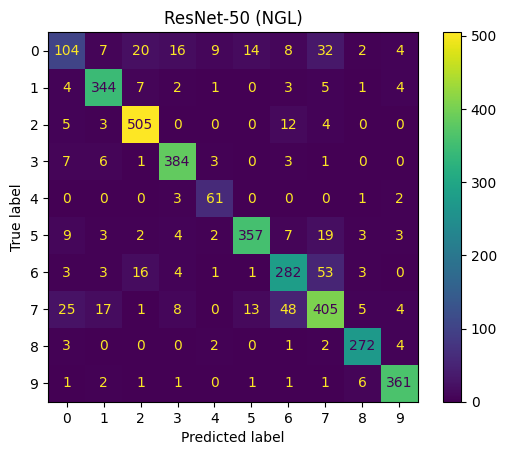

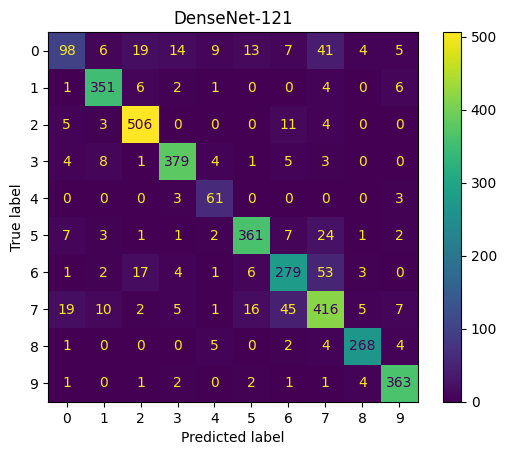

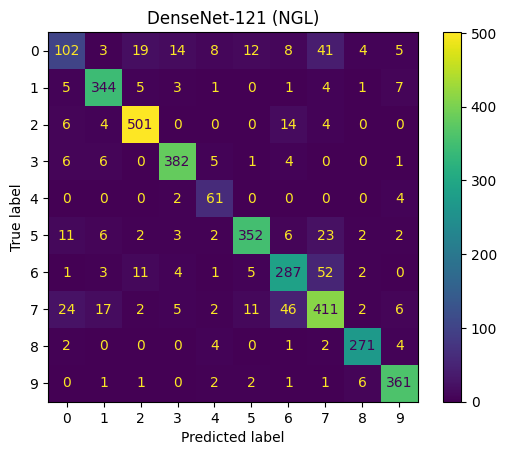

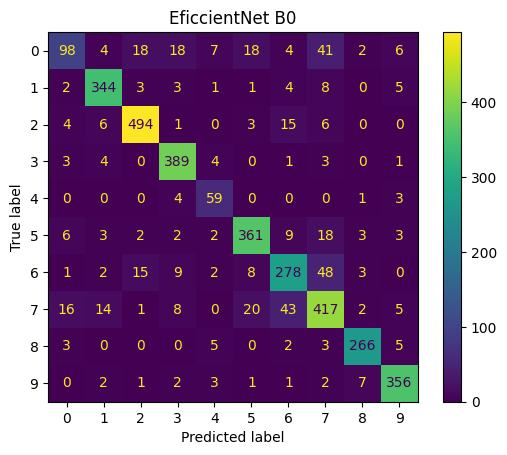

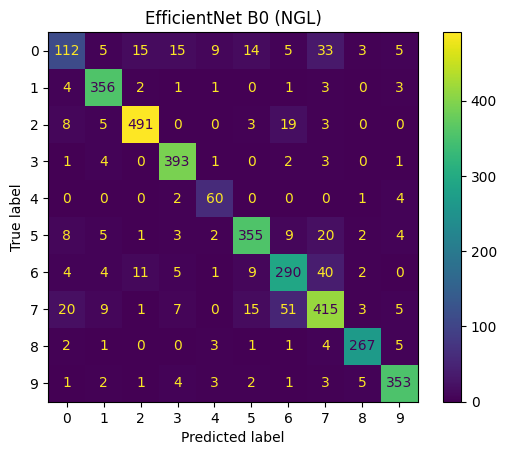

In [18]:
for model, (y, y_hat) in results.items():
    cm = metrics.confusion_matrix(y, y_hat)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(model_names[model])
    plt.show()

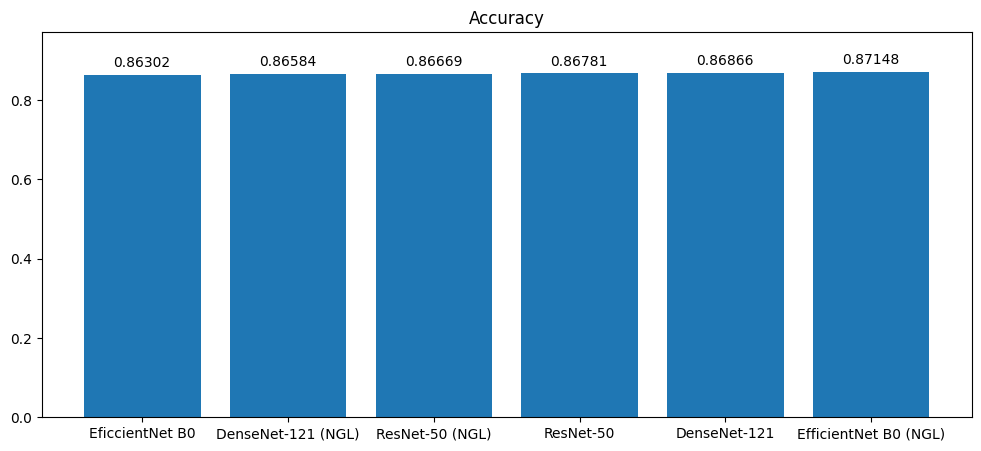

In [88]:
accuracies = sorted([(model_names[model], metrics.accuracy_score(y, y_hat)) for model, (y, y_hat) in results.items()], key=lambda data: data[1])

x, height = zip(*accuracies)
fig, ax1= plt.subplots(figsize=(12, 5))
bars = ax1.bar(x, height)
ax1.set_ylim(0, max(height) + 0.1)
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width() / 4, bar.get_height() + 0.03,
             f'{bar.get_height():.5f}', va='center', fontsize=10, color='black')

ax1.set_title("Accuracy")
plt.show()

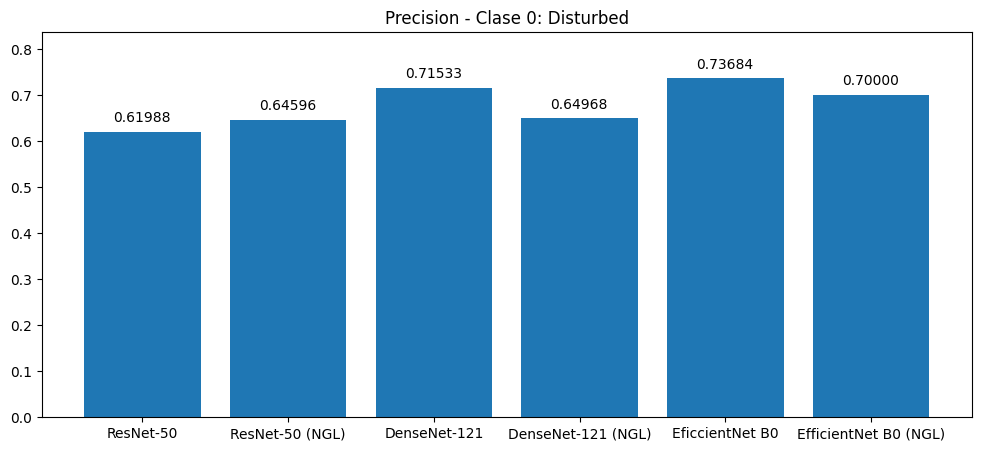

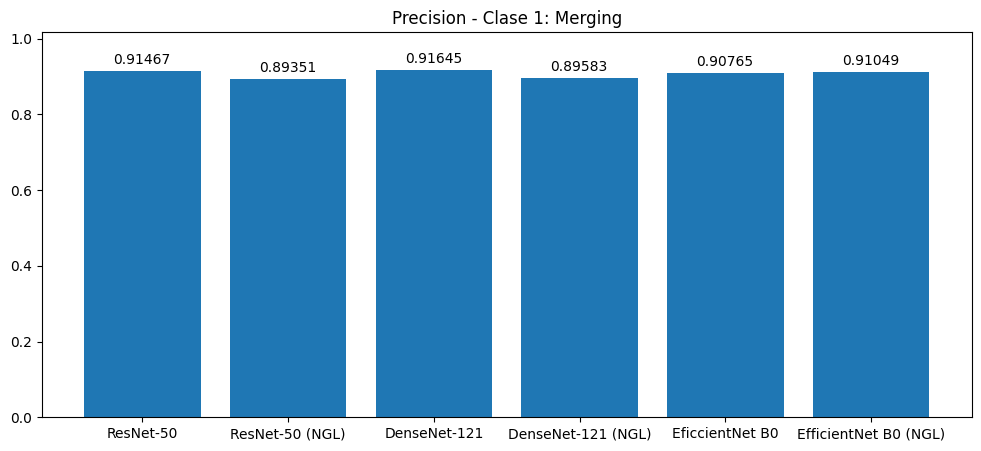

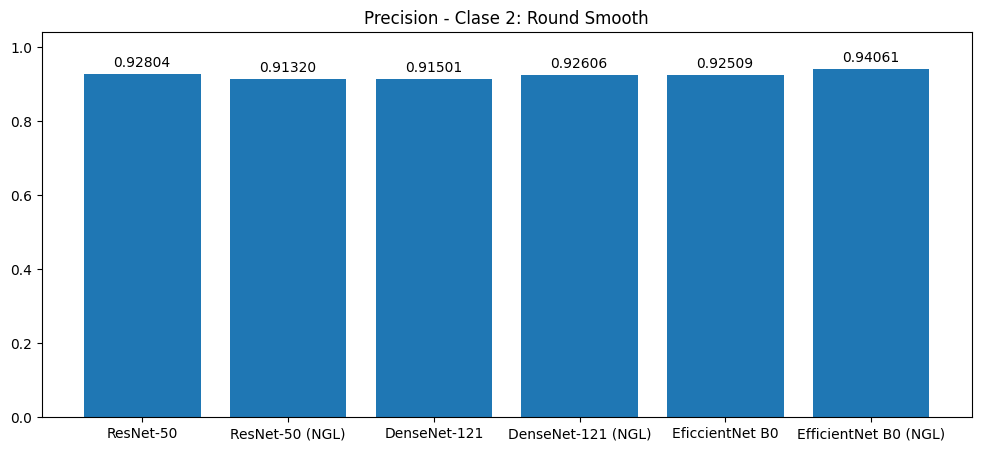

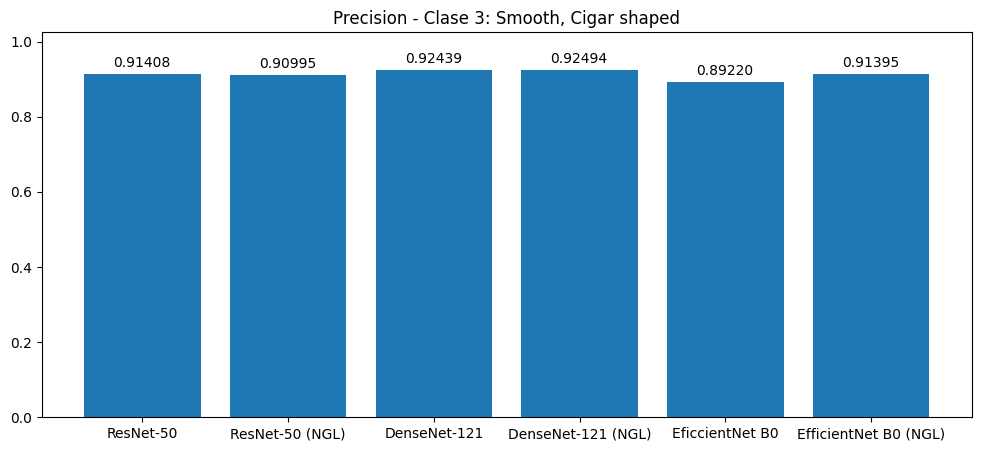

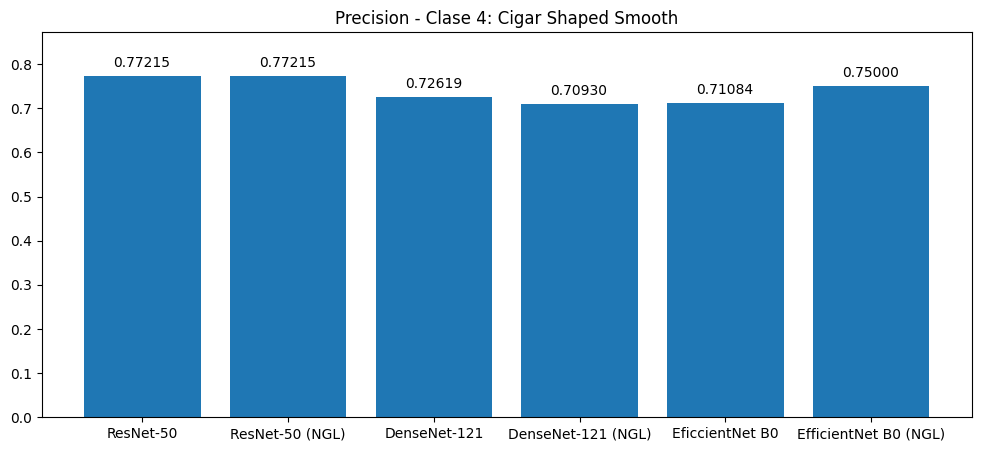

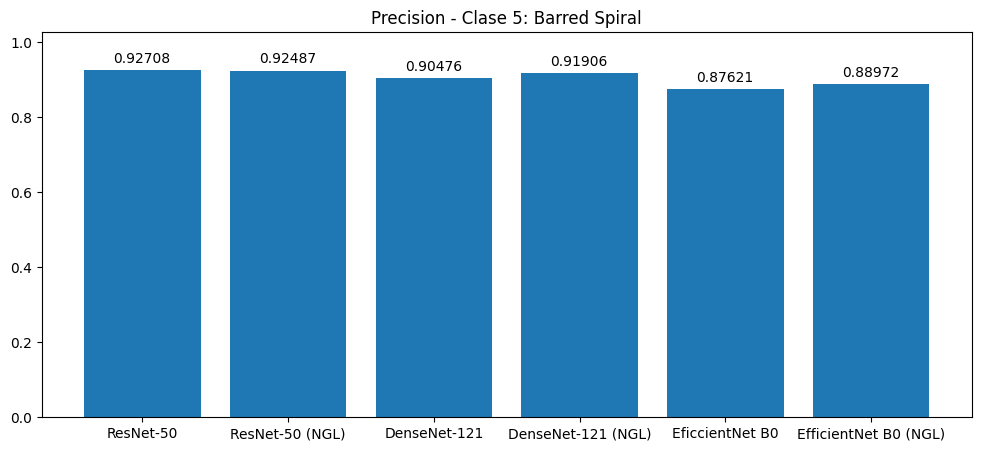

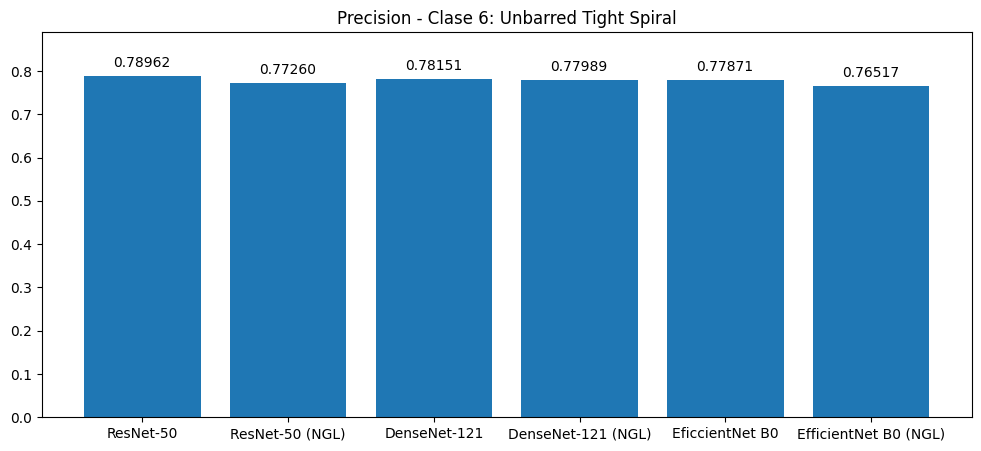

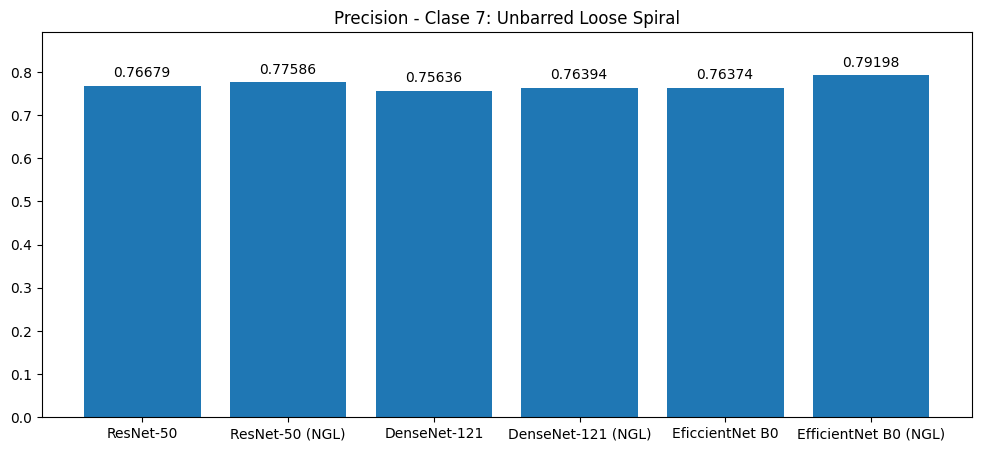

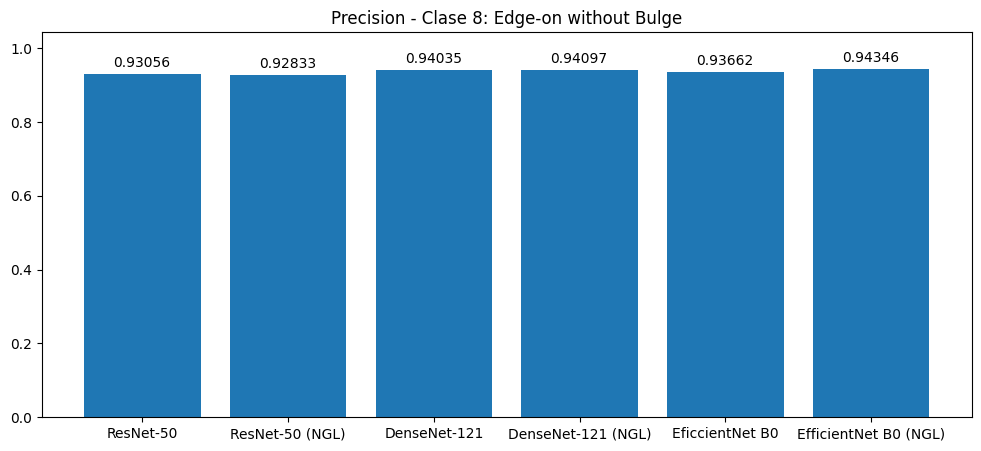

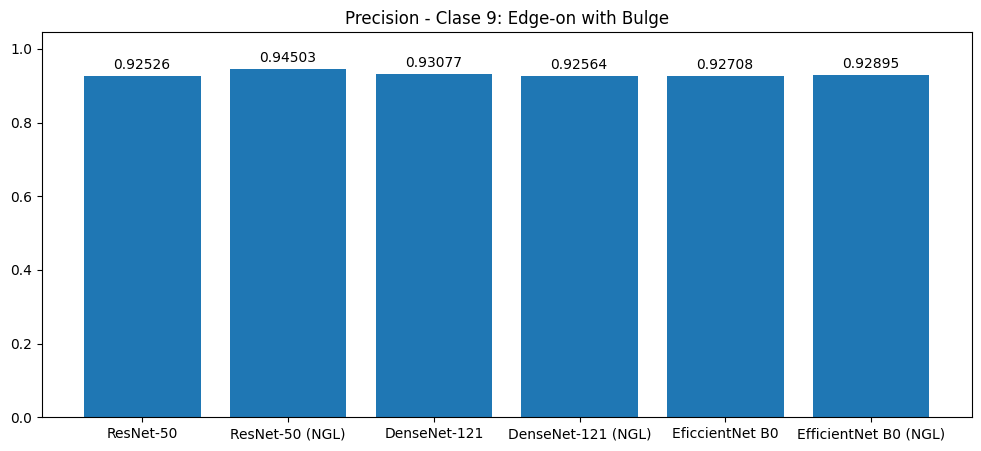

In [89]:
precisions = [(model_names[model], metrics.precision_score(y, y_hat, average=None)) for model, (y, y_hat) in results.items()]

x, height = zip(*precisions)
height_by_class = zip(*height)

for i, h in enumerate(height_by_class):
    fig, ax1= plt.subplots(figsize=(12, 5))
    bars = ax1.bar(x, h)
    ax1.set_ylim(0, max(h) + 0.1)
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width() / 4, bar.get_height() + 0.03,
                 f'{bar.get_height():.5f}', va='center', fontsize=10, color='black')

    ax1.set_title(f"Precision - Clase {i}: {galaxy10.galaxy10cls_lookup(i)}")
    plt.show()

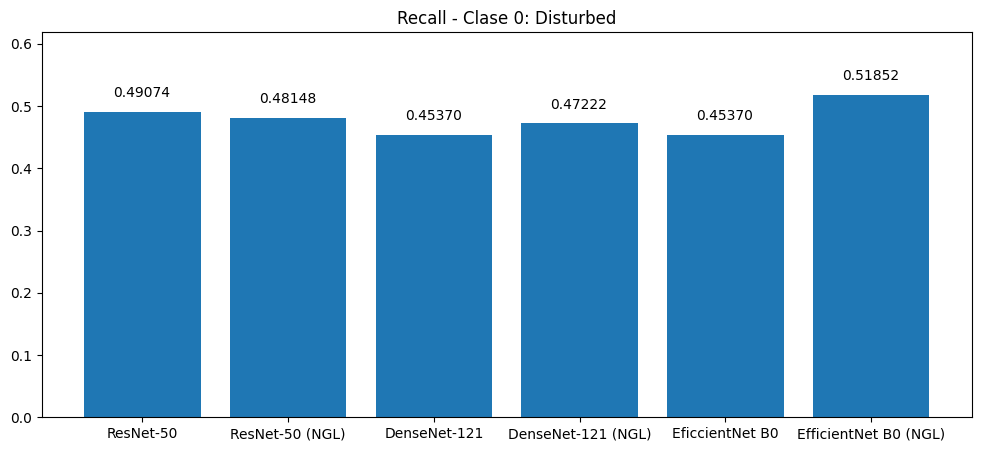

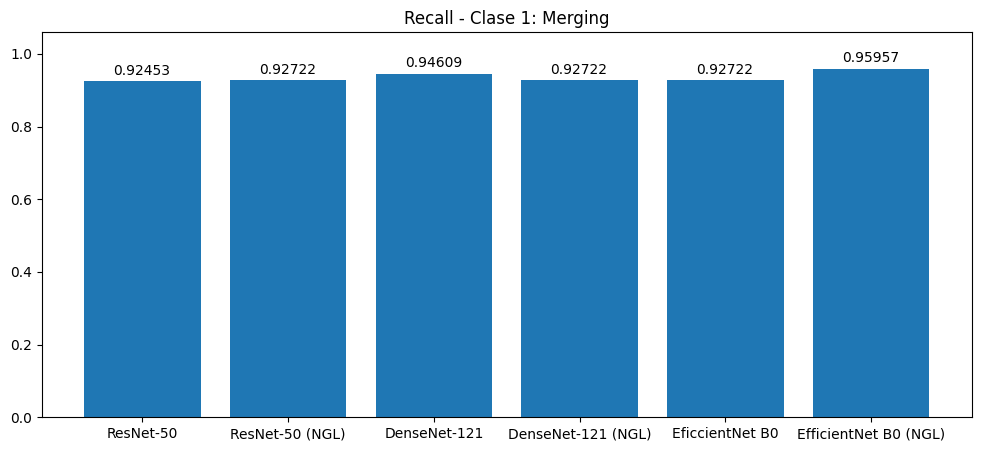

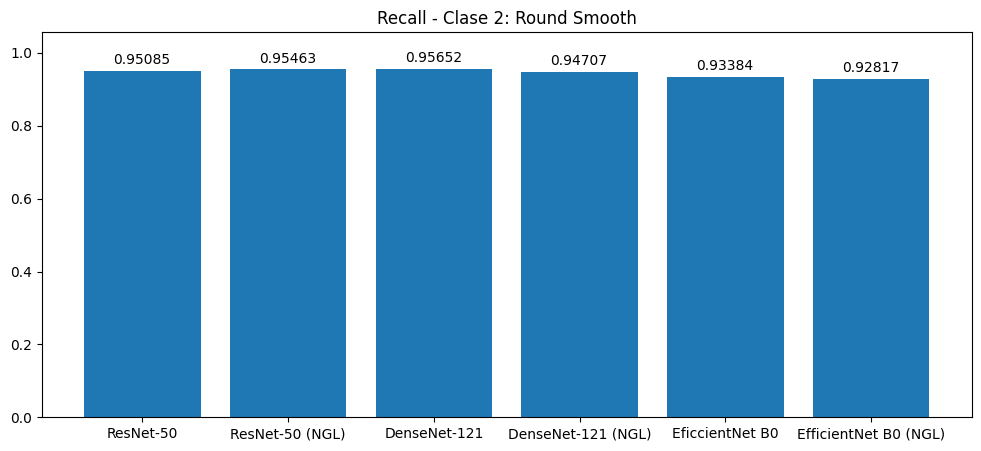

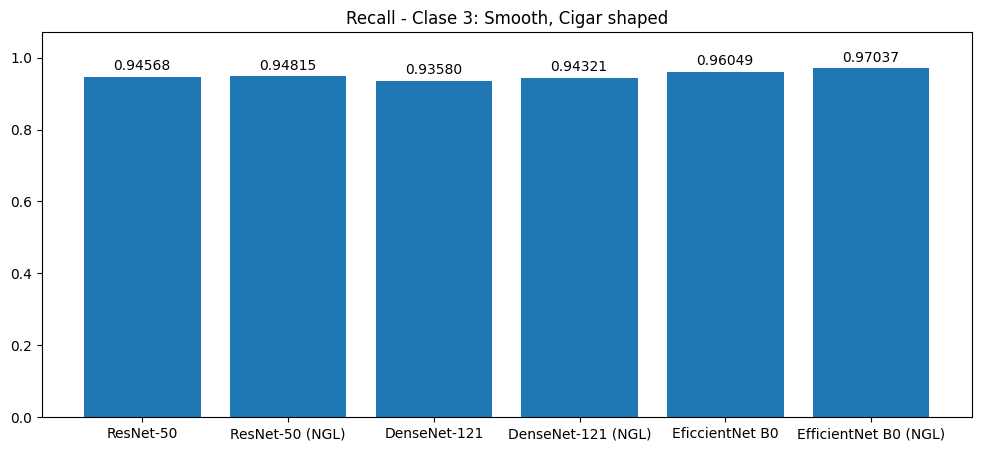

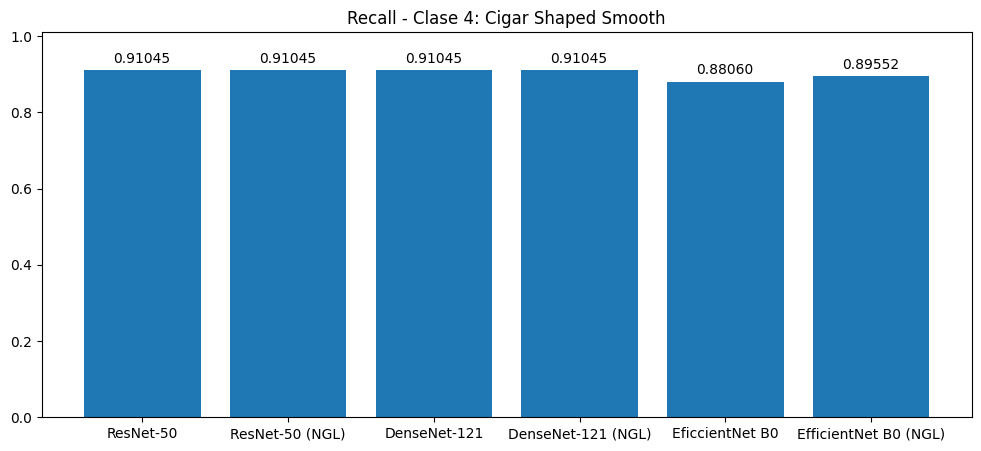

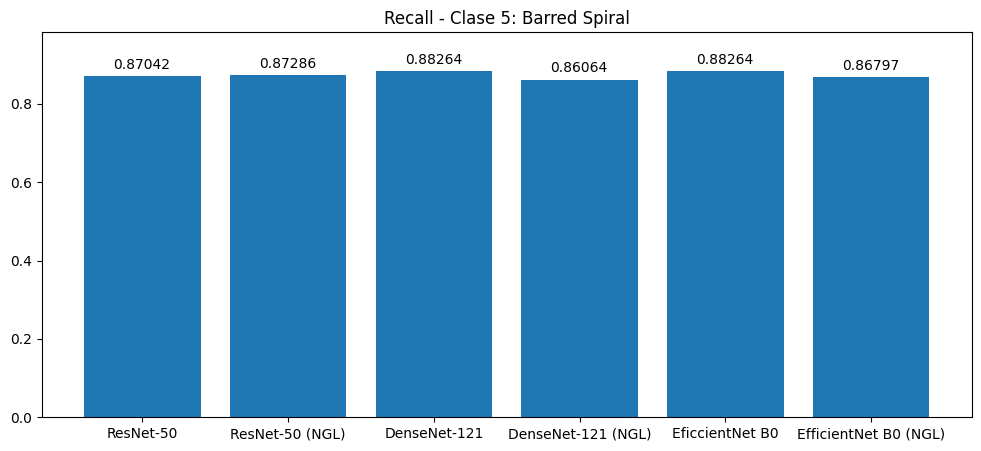

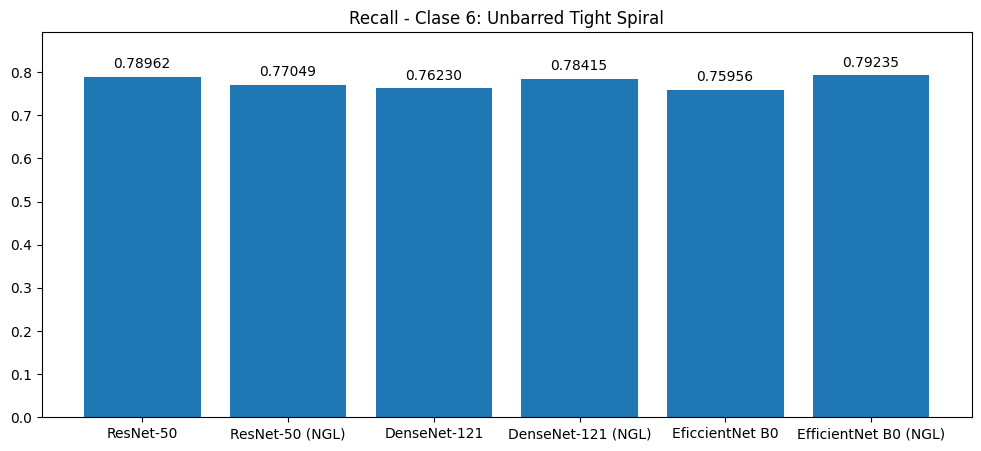

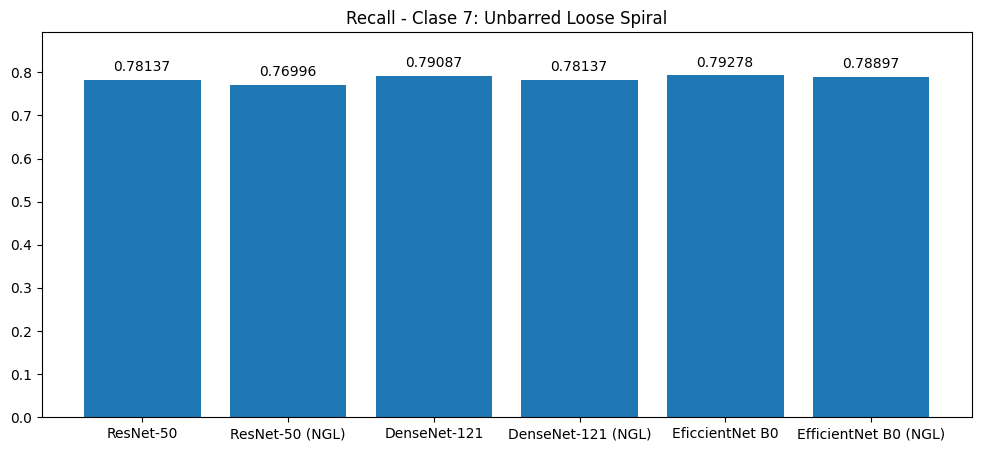

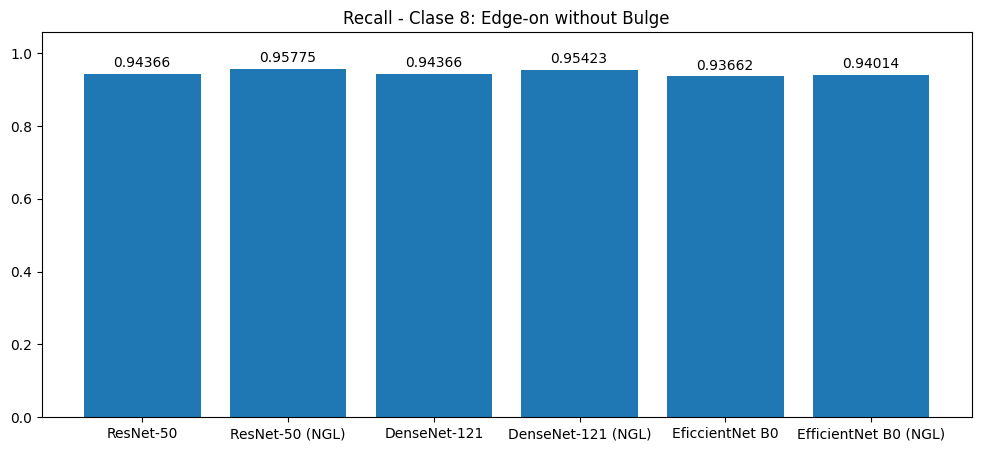

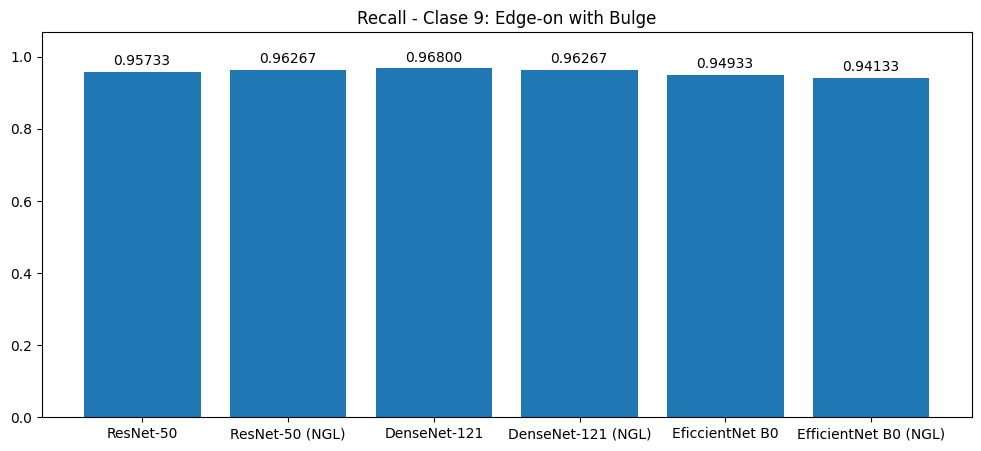

In [90]:
recalls = [(model_names[model], metrics.recall_score(y, y_hat, average=None)) for model, (y, y_hat) in results.items()]

x, height = zip(*recalls)
height_by_class = zip(*height)

for i, h in enumerate(height_by_class):
    fig, ax1= plt.subplots(figsize=(12, 5))
    bars = ax1.bar(x, h)
    ax1.set_ylim(0, max(h) + 0.1)
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width() / 4, bar.get_height() + 0.03,
                 f'{bar.get_height():.5f}', va='center', fontsize=10, color='black')

    ax1.set_title(f"Recall - Clase {i}: {galaxy10.galaxy10cls_lookup(i)}")
    plt.show()